In [2]:
import os.path
import numpy as np
import h5py
import tensorboard as tensorboard
from tensorboard.plugins import projector
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import leakage_models
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from sklearn.model_selection import train_test_split

# Choose a leakage model
LEAKAGE_MODEL = leakage_models.identity_sbox

In [3]:
root = r"C:\Users\nampo\Downloads"

in_file	 = h5py.File(os.path.join(root,"ascad-variable.h5"), "r")
print(in_file.keys())

# Load profiling traces
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.float64)
# Load profiling labels
Y_profiling = np.array(in_file['Profiling_traces/labels'], dtype = np.uint8)

# Load attacking traces
X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.float64)
# Load attacking labels
Y_attack = np.array(in_file['Attack_traces/labels'], dtype = np.uint8)

<KeysViewHDF5 ['Attack_traces', 'Profiling_traces']>


In [ ]:
print(X_profiling.shape)
print(X_attack)
print(Y_profiling.shape)
print(Y_attack)
print(min(Y_profiling), max(Y_profiling))
print(np.min(X_profiling), np.max(X_profiling))

In [ ]:
plt.plot(X_profiling[0,:])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_profiling, Y_profiling, test_size=0.3, random_state=42, shuffle=True)

batch_size = 4096
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

140000
140000


2023-03-21 13:22:21.036988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-21 13:22:21.059582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gabriel-IdeaPad-L340-17IRH-Gaming): /proc/driver/nvidia/version does not exist
2023-03-21 13:22:21.112748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 13:22:21.156315: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.
2023-03-21 13:22:36.435810: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 672000000 

In [44]:
#Create a new model that will replace template attack
from keras.layers import LeakyReLU
nb_classes = 256
input_shape = (32)
initializer = tk.initializers.GlorotUniform()
model = tk.models.Sequential()
model.add(tk.Input(shape=input_shape))
model.add(tkl.Dense(64, kernel_initializer=initializer))
model.add(LeakyReLU(alpha=0.05))
model.add(tkl.Dense(128, kernel_initializer=initializer))
model.add(LeakyReLU(alpha=0.05))
model.add(tkl.Dense(nb_classes, activation='softmax',kernel_initializer=initializer))
model.compile(
    optimizer=tk.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tk.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[tk.metrics.CategoricalAccuracy()],
)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               33024     
                                                                 
Total params: 43,456
Trainable params: 43,456
Non-trainable params: 0
_________________________________________________________________


/home/gabriel/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [27]:
#Create dataset
#The new model that we just built will have as inputs the predictions of the triplet model 
#and will output probability distribution for 256 classes
encoding_profiling = []
label_profiling = []
val_encoding_profiling = []
val_label_profiling = []
for step,(x_batch,labels) in enumerate(train_dataset):
    print(step)
    encoding_profiling.append(reconstructed_model.predict(x_batch))
    label_profiling.append(labels)

for step,(x_batch,labels) in enumerate(val_dataset):
    print(step)
    val_encoding_profiling.append(reconstructed_model.predict(x_batch))
    val_label_profiling.append(labels)

35
0
128/128 [==============================] - 2s 12ms/step
1
128/128 [==============================] - 2s 13ms/step
2
128/128 [==============================] - 1s 11ms/step
3
128/128 [==============================] - 2s 13ms/step
4
128/128 [==============================] - 1s 11ms/step
5
128/128 [==============================] - 1s 10ms/step
6
128/128 [==============================] - 2s 13ms/step
7
128/128 [==============================] - 2s 12ms/step
8
128/128 [==============================] - 2s 12ms/step
9
128/128 [==============================] - 1s 11ms/step
10
128/128 [==============================] - 2s 12ms/step
11
128/128 [==============================] - 1s 10ms/step
12
128/128 [==============================] - 1s 10ms/step
13
128/128 [==============================] - 1s 11ms/step
14
128/128 [==============================] - 1s 11ms/step
15
128/128 [==============================] - 1s 11ms/step
16
128/128 [==============================] - 1s 11ms/step
17
1

In [28]:
encoding_profiling_array = np.concatenate(encoding_profiling, axis = 0)
label_profiling_array = np.concatenate(label_profiling, axis = 0)

val_encoding_profiling_array = np.concatenate(val_encoding_profiling, axis = 0)
val_label_profiling_array = np.concatenate(val_label_profiling, axis = 0)

print(encoding_profiling_array.shape)

35 <class 'numpy.ndarray'> (4096, 32)
(140000, 32)


In [45]:
label_profiling_array = tf.one_hot(label_profiling_array,depth = 256) 
val_label_profiling_array = tf.one_hot(val_label_profiling_array,depth = 256) 
tf.config.run_functions_eagerly(True)
print(val_encoding_profiling_array.shape)
print(val_label_profiling_array.shape)
print(encoding_profiling_array.shape)
print(label_profiling_array.shape)

model.summary()
history = model.fit(x = encoding_profiling_array, y = label_profiling_array, epochs= 20, batch_size=64, validation_data = [val_encoding_profiling_array, val_label_profiling_array], validation_batch_size=64)

(60000, 32)
(60000, 256)
(140000, 32)
(140000, 256)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               33024     
                                                                 
Total params: 43,456
Trainable params: 43,456
Non-trainable params: 0
_______________________________________________________________

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2188/2188 [==============================] - 52s 24ms/step - loss: 5.9815 - categorical_accuracy: 0.0041 - val_loss: 5.5534 - val_categorical_accuracy: 0.0035
Epoch 2/20
2188/2188 [==============================] - 59s 27ms/step - loss: 5.5544 - categorical_accuracy: 0.0038 - val_loss: 5.5559 - val_categorical_accuracy: 0.0036
Epoch 3/20
2188/2188 [==============================] - 50s 23ms/step - loss: 5.5484 - categorical_accuracy: 0.0041 - val_loss: 5.5479 - val_categorical_accuracy: 0.0038
Epoch 4/20
2188/2188 [==============================] - 50s 23ms/step - loss: 5.5480 - categorical_accuracy: 0.0040 - val_loss: 5.5491 - val_categorical_accuracy: 0.0040
Epoch 5/20
2188/2188 [==============================] - 50s 23ms/step - loss: 5.5490 - categorical_accuracy: 0.0043 - val_loss: 5.5519 - val_categorical_accuracy: 0.0036
Epoch 6/20
2188/2188 [==============================] - 50s 23ms/step - loss: 5.5493 - categorical_accuracy: 0.0039 - val_loss: 5.5496 - val_categorical_accuracy

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


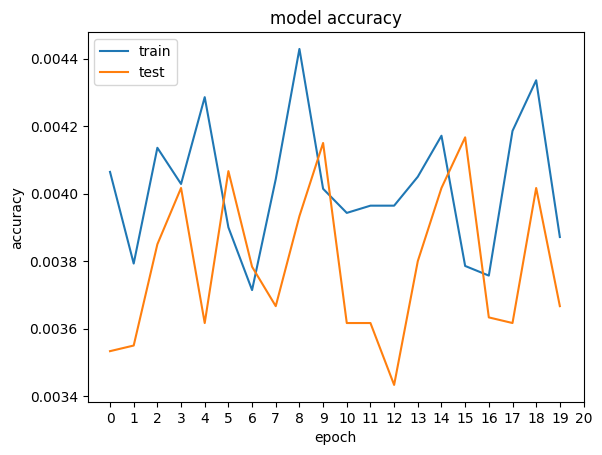

In [46]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
list_ticks = []
for i in range(0,21):
    list_ticks.append(int(i))
plt.xticks(list_ticks)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
#Save new model
model.save(os.path.join(root,"my_model32to256.h5"))

In [4]:
#Load Triplet model
reconstructed_model = tk.models.load_model(os.path.join(root,'mymodel20.h5'))

#Load or re-use model we just trained
model = tk.models.load_model(os.path.join(root,'my_model32to256.h5'))

In [5]:
#Build full model by concatenating the two models below

full_model = tk.Sequential()
for layer in reconstructed_model.layers:
    full_model.add(layer)
for layer in model.layers:
    full_model.add(layer)
full_model.summary()
full_model.compile(
    optimizer=tk.optimizers.Adam(learning_rate = 0.001),  # Optimizer
    # Loss function to minimize
    loss=tk.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[tk.metrics.CategoricalAccuracy()],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1400, 64)          1024      
                                                                 
 batch_normalization (BatchN  (None, 1400, 64)         256       
 ormalization)                                                   
                                                                 
 average_pooling1d (AverageP  (None, 93, 64)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 93, 128)          512       
 hNormalization)                                                 
                                                        

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_profiling, Y_profiling, test_size=0.3, random_state=42, shuffle=True)

In [7]:
tf.config.run_functions_eagerly(True)

In [8]:
tf.config.run_functions_eagerly(True)
full_history = full_model.fit(x = X_train, y = tf.one_hot(y_train,depth = 256), epochs= 10, batch_size=64, validation_data = [X_val, tf.one_hot(y_val, depth = 256)], validation_batch_size=64)
full_model.save(os.path.join(root,"full_model"))

C:\Users\nampo\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
2188/2188 [==============================] - 584s 267ms/step - loss: 5.5493 - categorical_accuracy: 0.0037 - val_loss: 5.5471 - val_categorical_accuracy: 0.0037
Epoch 2/10
2188/2188 [==============================] - 549s 251ms/step - loss: 5.5465 - categorical_accuracy: 0.0041 - val_loss: 5.5479 - val_categorical_accuracy: 0.0036
Epoch 3/10
2188/2188 [==============================] - 563s 257ms/step - loss: 5.5464 - categorical_accuracy: 0.0040 - val_loss: 5.5467 - val_categorical_accuracy: 0.0036
Epoch 4/10
2188/2188 [==============================] - 568s 260ms/step - loss: 5.5458 - categorical_accuracy: 0.0040 - val_loss: 5.5469 - val_categorical_accuracy: 0.0038
Epoch 5/10
2188/2188 [==============================] - 578s 264ms/step - loss: 5.5454 - categorical_accuracy: 0.0040 - val_loss: 5.5467 - val_categorical_accuracy: 0.0036
Epoch 6/10
2188/2188 [==============================] - 535s 245ms/step - loss: 5.5452 - categorical_accuracy: 0.0040 - val_loss: 5.5466 - v

INFO:tensorflow:Assets written to: C:\Users\nampo\Downloads\full_model\assets


INFO:tensorflow:Assets written to: C:\Users\nampo\Downloads\full_model\assets


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


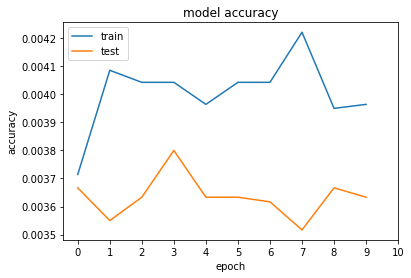

In [9]:
# list all data in history
print(full_history.history.keys())
# summarize history for accuracy
plt.plot(full_history.history['categorical_accuracy'])
plt.plot(full_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
list_ticks = []
for i in range(0,11):
    list_ticks.append(int(i))
plt.xticks(list_ticks)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

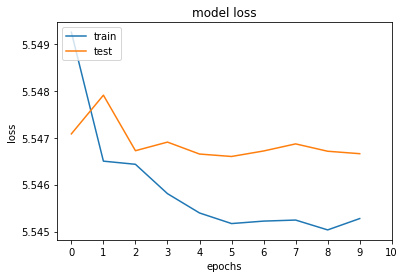

In [26]:
plt.figure()
plt.plot(full_history.history['loss'])
plt.plot(full_history.history['val_loss'])
plt.title("model loss")
list_ticks = []
for i in range(0,11):
    list_ticks.append(int(i))
plt.xticks(list_ticks)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
root =r"C:\Users\nampo\Downloads"
data = h5py.File(os.path.join(root,"ascad-variable.h5"), "r")
SUBKEY_INDEX = 2

test_traces = data["Attack_traces"]["traces"]
test_plaintexts = data["Attack_traces"]["metadata"]["plaintext"][:, SUBKEY_INDEX]
test_keys = data["Attack_traces"]["metadata"]["key"][:, SUBKEY_INDEX]

num_test_traces, num_samples = test_traces.shape
print(f"Number of traces: {num_test_traces}, number of samples: {num_samples}")

# Check data shapes
assert(test_plaintexts.shape == (num_test_traces,))
assert(test_keys.shape == (num_test_traces,))

# Extraction of the secret key (must be the same for all traces)
SECRET_KEY = test_keys[0]
assert(np.all(test_keys == SECRET_KEY))
print(test_keys)
print(SECRET_KEY)
print(f"Secret key is {SECRET_KEY:#04x}")

98


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

32/32 [==============================] - 1s 29ms/step


  1%|▊                                                                                | 1/98 [01:16<2:04:02, 76.73s/it]

32/32 [==============================] - 1s 26ms/step


  2%|█▋                                                                               | 2/98 [02:38<2:07:03, 79.41s/it]

32/32 [==============================] - 1s 29ms/step


  3%|██▍                                                                              | 3/98 [03:49<2:00:06, 75.85s/it]

32/32 [==============================] - 1s 26ms/step


  4%|███▎                                                                             | 4/98 [04:57<1:53:46, 72.62s/it]

32/32 [==============================] - 1s 26ms/step


  5%|████▏                                                                            | 5/98 [06:04<1:49:41, 70.77s/it]

32/32 [==============================] - 1s 26ms/step


  6%|████▉                                                                            | 6/98 [07:14<1:48:00, 70.44s/it]

32/32 [==============================] - 1s 26ms/step


  7%|█████▊                                                                           | 7/98 [08:22<1:45:21, 69.47s/it]

32/32 [==============================] - 1s 26ms/step


  8%|██████▌                                                                          | 8/98 [09:29<1:43:12, 68.80s/it]

32/32 [==============================] - 1s 28ms/step


  9%|███████▍                                                                         | 9/98 [10:41<1:43:26, 69.73s/it]

32/32 [==============================] - 1s 29ms/step


 10%|████████▏                                                                       | 10/98 [11:48<1:41:14, 69.03s/it]

32/32 [==============================] - 1s 26ms/step


 11%|████████▉                                                                       | 11/98 [12:56<1:39:20, 68.51s/it]

32/32 [==============================] - 1s 30ms/step


 12%|█████████▊                                                                      | 12/98 [14:03<1:37:56, 68.33s/it]

32/32 [==============================] - 1s 28ms/step


 13%|██████████▌                                                                     | 13/98 [15:12<1:36:46, 68.31s/it]

32/32 [==============================] - 1s 27ms/step


 14%|███████████▍                                                                    | 14/98 [16:19<1:35:10, 67.99s/it]

32/32 [==============================] - 1s 26ms/step


 15%|████████████▏                                                                   | 15/98 [17:26<1:33:42, 67.75s/it]

32/32 [==============================] - 1s 25ms/step


 16%|█████████████                                                                   | 16/98 [18:33<1:32:23, 67.61s/it]

32/32 [==============================] - 1s 26ms/step


 17%|█████████████▉                                                                  | 17/98 [19:41<1:31:06, 67.49s/it]

32/32 [==============================] - 1s 25ms/step


 18%|██████████████▋                                                                 | 18/98 [20:49<1:30:15, 67.70s/it]

32/32 [==============================] - 1s 26ms/step


 19%|███████████████▌                                                                | 19/98 [21:56<1:29:01, 67.62s/it]

32/32 [==============================] - 1s 25ms/step


 20%|████████████████▎                                                               | 20/98 [23:04<1:28:00, 67.70s/it]

32/32 [==============================] - 1s 26ms/step


 21%|█████████████████▏                                                              | 21/98 [24:13<1:27:13, 67.96s/it]

32/32 [==============================] - 1s 25ms/step


 22%|█████████████████▉                                                              | 22/98 [25:20<1:25:47, 67.73s/it]

32/32 [==============================] - 1s 25ms/step


 23%|██████████████████▊                                                             | 23/98 [26:27<1:24:31, 67.62s/it]

32/32 [==============================] - 1s 25ms/step


 24%|███████████████████▌                                                            | 24/98 [27:36<1:23:42, 67.87s/it]

32/32 [==============================] - 1s 27ms/step


 26%|████████████████████▍                                                           | 25/98 [28:44<1:22:34, 67.86s/it]

32/32 [==============================] - 1s 27ms/step


 27%|█████████████████████▏                                                          | 26/98 [29:52<1:21:30, 67.93s/it]

32/32 [==============================] - 1s 27ms/step


 28%|██████████████████████                                                          | 27/98 [31:00<1:20:26, 67.97s/it]

32/32 [==============================] - 1s 26ms/step


 29%|██████████████████████▊                                                         | 28/98 [32:08<1:19:22, 68.04s/it]

32/32 [==============================] - 1s 27ms/step


 30%|███████████████████████▋                                                        | 29/98 [33:16<1:18:13, 68.02s/it]

32/32 [==============================] - 1s 27ms/step


 31%|████████████████████████▍                                                       | 30/98 [34:23<1:16:56, 67.89s/it]

32/32 [==============================] - 1s 27ms/step


 32%|█████████████████████████▎                                                      | 31/98 [35:31<1:15:43, 67.82s/it]

32/32 [==============================] - 1s 27ms/step


 33%|██████████████████████████                                                      | 32/98 [36:39<1:14:34, 67.79s/it]

32/32 [==============================] - 1s 27ms/step


 34%|██████████████████████████▉                                                     | 33/98 [37:46<1:13:21, 67.72s/it]

32/32 [==============================] - 1s 27ms/step


 35%|███████████████████████████▊                                                    | 34/98 [38:54<1:12:10, 67.67s/it]

32/32 [==============================] - 1s 25ms/step


 36%|████████████████████████████▌                                                   | 35/98 [40:02<1:11:07, 67.74s/it]

32/32 [==============================] - 1s 25ms/step


 37%|█████████████████████████████▍                                                  | 36/98 [41:09<1:09:48, 67.56s/it]

32/32 [==============================] - 1s 25ms/step


 38%|██████████████████████████████▏                                                 | 37/98 [42:18<1:09:01, 67.89s/it]

32/32 [==============================] - 1s 25ms/step


 39%|███████████████████████████████                                                 | 38/98 [43:27<1:08:22, 68.38s/it]

32/32 [==============================] - 1s 33ms/step


 40%|███████████████████████████████▊                                                | 39/98 [44:36<1:07:24, 68.55s/it]

32/32 [==============================] - 1s 26ms/step


 41%|████████████████████████████████▋                                               | 40/98 [45:46<1:06:32, 68.84s/it]

32/32 [==============================] - 1s 27ms/step


 42%|█████████████████████████████████▍                                              | 41/98 [46:54<1:05:18, 68.75s/it]

32/32 [==============================] - 1s 26ms/step


 43%|██████████████████████████████████▎                                             | 42/98 [48:07<1:05:24, 70.08s/it]

32/32 [==============================] - 1s 25ms/step


 44%|███████████████████████████████████                                             | 43/98 [49:19<1:04:38, 70.51s/it]

32/32 [==============================] - 1s 26ms/step


 45%|███████████████████████████████████▉                                            | 44/98 [50:30<1:03:29, 70.56s/it]

32/32 [==============================] - 1s 25ms/step


 46%|████████████████████████████████████▋                                           | 45/98 [51:41<1:02:35, 70.85s/it]

32/32 [==============================] - 1s 28ms/step


 47%|█████████████████████████████████████▌                                          | 46/98 [52:58<1:02:51, 72.52s/it]

32/32 [==============================] - 1s 37ms/step


 48%|██████████████████████████████████████▎                                         | 47/98 [54:20<1:04:03, 75.37s/it]

32/32 [==============================] - 1s 36ms/step


 49%|███████████████████████████████████████▏                                        | 48/98 [55:42<1:04:28, 77.36s/it]

32/32 [==============================] - 1s 27ms/step


 50%|████████████████████████████████████████                                        | 49/98 [56:52<1:01:29, 75.30s/it]

32/32 [==============================] - 1s 27ms/step


 51%|█████████████████████████████████████████▊                                        | 50/98 [58:03<59:10, 73.96s/it]

32/32 [==============================] - 1s 30ms/step


 52%|██████████████████████████████████████████▋                                       | 51/98 [59:12<56:50, 72.57s/it]

32/32 [==============================] - 1s 27ms/step


 53%|██████████████████████████████████████████▍                                     | 52/98 [1:00:19<54:24, 70.97s/it]

32/32 [==============================] - 1s 27ms/step


 54%|███████████████████████████████████████████▎                                    | 53/98 [1:01:27<52:34, 70.10s/it]

32/32 [==============================] - 1s 24ms/step


 55%|████████████████████████████████████████████                                    | 54/98 [1:02:36<51:03, 69.62s/it]

32/32 [==============================] - 1s 25ms/step


 56%|████████████████████████████████████████████▉                                   | 55/98 [1:03:43<49:23, 68.92s/it]

32/32 [==============================] - 1s 25ms/step


 57%|█████████████████████████████████████████████▋                                  | 56/98 [1:04:50<47:52, 68.40s/it]

32/32 [==============================] - 1s 24ms/step


 58%|██████████████████████████████████████████████▌                                 | 57/98 [1:06:03<47:30, 69.51s/it]

32/32 [==============================] - 1s 29ms/step


 59%|███████████████████████████████████████████████▎                                | 58/98 [1:07:21<48:07, 72.18s/it]

32/32 [==============================] - 1s 25ms/step


 60%|████████████████████████████████████████████████▏                               | 59/98 [1:08:35<47:12, 72.62s/it]

32/32 [==============================] - 1s 36ms/step


 61%|████████████████████████████████████████████████▉                               | 60/98 [1:09:47<45:57, 72.56s/it]

32/32 [==============================] - 1s 25ms/step


 62%|█████████████████████████████████████████████████▊                              | 61/98 [1:11:01<44:58, 72.92s/it]

32/32 [==============================] - 1s 30ms/step


 63%|██████████████████████████████████████████████████▌                             | 62/98 [1:12:15<43:56, 73.25s/it]

32/32 [==============================] - 2s 64ms/step


 64%|███████████████████████████████████████████████████▍                            | 63/98 [1:13:35<43:56, 75.32s/it]

32/32 [==============================] - 1s 42ms/step


 65%|████████████████████████████████████████████████████▏                           | 64/98 [1:14:47<42:03, 74.21s/it]

32/32 [==============================] - 1s 24ms/step


 66%|█████████████████████████████████████████████████████                           | 65/98 [1:15:58<40:19, 73.31s/it]

32/32 [==============================] - 1s 34ms/step


 67%|█████████████████████████████████████████████████████▉                          | 66/98 [1:17:07<38:26, 72.07s/it]

32/32 [==============================] - 1s 26ms/step


 68%|██████████████████████████████████████████████████████▋                         | 67/98 [1:18:16<36:48, 71.25s/it]

32/32 [==============================] - 1s 25ms/step


 69%|███████████████████████████████████████████████████████▌                        | 68/98 [1:19:25<35:15, 70.53s/it]

32/32 [==============================] - 1s 27ms/step


 70%|████████████████████████████████████████████████████████▎                       | 69/98 [1:20:34<33:53, 70.13s/it]

32/32 [==============================] - 1s 26ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 70/98 [1:21:42<32:25, 69.49s/it]

32/32 [==============================] - 1s 25ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 71/98 [1:22:50<31:03, 69.01s/it]

32/32 [==============================] - 1s 28ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 72/98 [1:24:00<30:00, 69.23s/it]

32/32 [==============================] - 1s 28ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 73/98 [1:25:11<29:02, 69.72s/it]

32/32 [==============================] - 1s 28ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 74/98 [1:26:21<27:52, 69.70s/it]

32/32 [==============================] - 1s 28ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 75/98 [1:27:32<26:56, 70.28s/it]

32/32 [==============================] - 1s 28ms/step


 78%|██████████████████████████████████████████████████████████████                  | 76/98 [1:28:42<25:45, 70.25s/it]

32/32 [==============================] - 1s 26ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 77/98 [1:29:51<24:27, 69.86s/it]

32/32 [==============================] - 1s 30ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 78/98 [1:31:02<23:25, 70.26s/it]

32/32 [==============================] - 1s 25ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 79/98 [1:32:12<22:12, 70.12s/it]

32/32 [==============================] - 1s 28ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 80/98 [1:33:23<21:04, 70.25s/it]

32/32 [==============================] - 1s 25ms/step


 83%|██████████████████████████████████████████████████████████████████              | 81/98 [1:34:32<19:48, 69.92s/it]

32/32 [==============================] - 1s 27ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 82/98 [1:35:42<18:39, 70.00s/it]

32/32 [==============================] - 1s 28ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 83/98 [1:36:51<17:25, 69.68s/it]

32/32 [==============================] - 1s 25ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 84/98 [1:38:01<16:18, 69.89s/it]

32/32 [==============================] - 1s 25ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 85/98 [1:39:23<15:52, 73.26s/it]

32/32 [==============================] - 1s 28ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 86/98 [1:40:33<14:28, 72.41s/it]

32/32 [==============================] - 1s 24ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 87/98 [1:41:42<13:03, 71.26s/it]

32/32 [==============================] - 1s 25ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 88/98 [1:42:50<11:43, 70.33s/it]

32/32 [==============================] - 1s 25ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 89/98 [1:44:00<10:32, 70.24s/it]

32/32 [==============================] - 1s 24ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 90/98 [1:45:10<09:20, 70.12s/it]

32/32 [==============================] - 1s 27ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 91/98 [1:46:19<08:09, 69.88s/it]

32/32 [==============================] - 1s 24ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 92/98 [1:47:32<07:04, 70.77s/it]

32/32 [==============================] - 1s 26ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 93/98 [1:48:42<05:53, 70.66s/it]

32/32 [==============================] - 1s 27ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 94/98 [1:49:53<04:42, 70.57s/it]

32/32 [==============================] - 1s 25ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 95/98 [1:51:00<03:28, 69.56s/it]

32/32 [==============================] - 1s 25ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 96/98 [1:52:10<02:19, 69.76s/it]

32/32 [==============================] - 1s 25ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 97/98 [1:53:17<01:08, 68.94s/it]

21/21 [==============================] - 1s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [1:54:05<00:00, 69.85s/it]


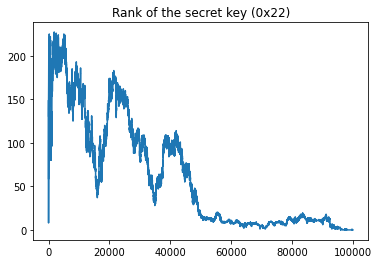

In [25]:
#Prediction using ranking

rank_of_secret_key = []

batch_size = 1024
attack_dataset = tf.data.Dataset.from_tensor_slices((test_plaintexts, test_traces))
attack_dataset = attack_dataset.batch(batch_size)

key_probabilities = np.zeros(256)
print(len(attack_dataset))
for pt, trace in tqdm(attack_dataset, total=len(attack_dataset)):
    # Extract the points of interest
    #feature_vector = trace[poi_indices]
    trace = trace[:,:,np.newaxis]
    feature_vector = full_model.predict(trace)
    
    for i in range(feature_vector.shape[0]):
        # Compute the probabilities for each label
        label_probabilities = {label: feature_vector[i,label] for label in range(256)}

        # Update the key probabilities
        for k in range(256):
            key_probabilities[k] += label_probabilities[LEAKAGE_MODEL(pt[i], k)]

        # Get the rank of the secret key
        rank_of_secret_key.append(np.count_nonzero(key_probabilities > key_probabilities[SECRET_KEY]))
        
    #print(feature_vector.shape, feature_vector)
    #key_probabilities = np.concatenate((key_probabilities, feature_vector[np.newaxis,:]), axis = 0)
    #rank = np.argsort(np.mean(key_probabilities, axis = 0))
    #index_key = np.where(rank == SECRET_KEY)
    #print(index_key)
    #rank_of_secret_key.append(index_key)

plt.plot(rank_of_secret_key)
plt.title(f"Rank of the secret key ({SECRET_KEY:#04x})")
plt.show()

In [27]:
first = np.where(np.array(rank_of_secret_key) == 0)
print(first)

(array([95925, 95926, 95927, ..., 99997, 99998, 99999], dtype=int64),)


95925


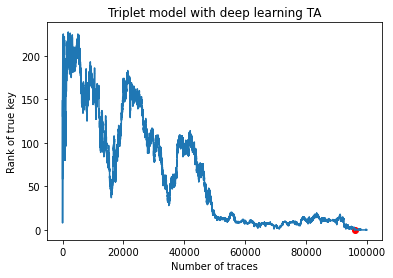

In [46]:
print(first[0][0])
plt.plot(rank_of_secret_key)
plt.ylabel("Rank of true key")
plt.xlabel("Number of traces")
plt.title("Simple model MLP")
plt.scatter(first[0][0],rank_of_secret_key[first[0][0]], c="red")